In [1]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.layers import LSTM
from keras  import callbacks
from keras import optimizers
import pandas as pd 
import tensorflow as tf
import numpy as np

Using TensorFlow backend.


In [2]:
df1 = pd.read_csv('/Users/pradeep/exp/capstone/data/Fine_2014_2019_Finger_millet_Min_Blore_Mysore.csv')
df1.head()

,district,commodity,Arrival Date,variety,Min_price
0,Mysore,Ragi (Finger Millet),02-01-14,Fine,1600
1,Mysore,Ragi (Finger Millet),03-01-14,Fine,2000
2,Mysore,Ragi (Finger Millet),04-01-14,Fine,1800
3,Mysore,Ragi (Finger Millet),07-01-14,Fine,2000
4,Mysore,Ragi (Finger Millet),08-01-14,Fine,2100


In [3]:
gp = pd.pivot_table(df1,values='Min_price',columns=['district','commodity'],index=['Arrival Date'])
#gp = gp.sort_index(axis='columns', level='Arrival Date')
#gp.head()

In [4]:
flattened = pd.DataFrame(gp.to_records())
flattened['Arrival Date'] = pd.to_datetime(flattened['Arrival Date'])
flattened = flattened.sort_values(by=['Arrival Date'])
df = flattened.reset_index()
del df['index']

df = df.set_index('Arrival Date').asfreq('D')
df = df.fillna(method='ffill')
df.head()

,"('Bangalore', 'Ragi (Finger Millet)')","('Mysore', 'Ragi (Finger Millet)')"
Arrival Date,,
2014-01-03,1800.0,1800.0
2014-01-04,1800.0,1800.0
2014-01-05,1800.0,1800.0
2014-01-06,1800.0,1800.0
2014-01-07,1700.0,1700.0


In [5]:
df.to_csv('/Users/pradeep/exp/capstone/data/Finger_millet_2006_2019_Complete_after_PreProcessing.csv', encoding='utf-8')

In [6]:
df = pd.read_csv('/Users/pradeep/exp/capstone/data/Finger_millet_2006_2019_Complete_after_PreProcessing.csv')


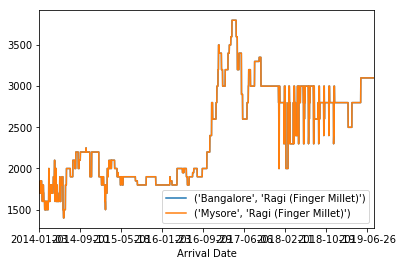

In [7]:
df.plot(x='Arrival Date')

In [8]:
df['Arrival Date'] = pd.to_datetime(df['Arrival Date']).astype('int')
df.describe()

,Arrival Date,"('Bangalore', 'Ragi (Finger Millet)')","('Mysore', 'Ragi (Finger Millet)')"
count,2.044000e+03,2044.00000,2044.00000
mean,1.476965e+18,2406.38454,2406.38454
std,5.099296e+16,566.48057,566.48057
min,1.388707e+18,1400.00000,1400.00000
25%,1.432836e+18,1900.00000,1900.00000
50%,1.476965e+18,2200.00000,2200.00000
75%,1.521094e+18,3000.00000,3000.00000
max,1.565222e+18,3800.00000,3800.00000


In [9]:
training_set = df.iloc[:,[1,2]].values
training_set

array([[1800., 1800.],
       [1800., 1800.],
       [1800., 1800.],
       ...,
       [3100., 3100.],
       [3100., 3100.],
       [3100., 3100.]])

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(training_set)

In [11]:
train_size = int(len(scaled) * 0.75)
test_size = len(scaled - train_size)
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 1533
test: 511


In [12]:
print(train.shape)
print(test.shape)

(1533, 2)
(511, 2)


In [13]:
train

array([[0.16666667, 0.16666667],
       [0.16666667, 0.16666667],
       [0.16666667, 0.16666667],
       ...,
       [0.375     , 0.375     ],
       [0.375     , 0.375     ],
       [0.375     , 0.375     ]])

In [14]:
def create_dataset(dataset, look_back=32):
    print(len(dataset), look_back)
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        b = dataset[i + look_back]
        dataX.append(a)
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

In [15]:
look_back = 16
#32
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

1533 16
511 16


In [16]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1516, 16, 2)
(494, 16, 2)
(1516, 2)
(494, 2)


In [17]:
#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],X_train.shape[2] ))
#X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))
print(X_train.shape)
print(X_test.shape)

(1516, 16, 2)
(494, 16, 2)


In [24]:
batch_size = 2
model = Sequential()
model.add(LSTM(units=400, batch_input_shape=(batch_size, look_back, 2), stateful=True))
#model.add(LSTM(50, return_sequences=True))  
#model.add(LSTM(units=100, batch_input_shape=(batch_size, look_back, 1), stateful=True))

model.add(Dense(2))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (2, 400)                  644800    
_________________________________________________________________
dense_2 (Dense)              (2, 2)                    802       
Total params: 645,602
Trainable params: 645,602
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.fit(X_train, y_train, epochs=150, batch_size=batch_size, verbose=2, shuffle=True)

Epoch 1/150
 - 12s - loss: 0.0040
Epoch 2/150
 - 12s - loss: 0.0018
Epoch 3/150
 - 12s - loss: 0.0014
Epoch 4/150
 - 12s - loss: 0.0014
Epoch 5/150
 - 12s - loss: 0.0013
Epoch 6/150
 - 12s - loss: 0.0013
Epoch 7/150
 - 12s - loss: 0.0013
Epoch 8/150
 - 12s - loss: 0.0013
Epoch 9/150
 - 12s - loss: 0.0012
Epoch 10/150
 - 12s - loss: 0.0013
Epoch 11/150
 - 12s - loss: 0.0012
Epoch 12/150
 - 12s - loss: 0.0013
Epoch 13/150
 - 12s - loss: 0.0012
Epoch 14/150
 - 12s - loss: 0.0012
Epoch 15/150
 - 12s - loss: 0.0012
Epoch 16/150
 - 13s - loss: 0.0012
Epoch 17/150
 - 12s - loss: 0.0012
Epoch 18/150
 - 12s - loss: 0.0012
Epoch 19/150
 - 12s - loss: 0.0011
Epoch 20/150
 - 14s - loss: 0.0012
Epoch 21/150
 - 13s - loss: 0.0011
Epoch 22/150
 - 13s - loss: 0.0011
Epoch 23/150
 - 15s - loss: 0.0011
Epoch 24/150
 - 13s - loss: 0.0011
Epoch 25/150
 - 13s - loss: 0.0011
Epoch 26/150
 - 13s - loss: 0.0011
Epoch 27/150
 - 13s - loss: 0.0011
Epoch 28/150
 - 13s - loss: 0.0011
Epoch 29/150
 - 14s - loss: 0

In [26]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 2))

In [27]:
#X_test

In [28]:
#testPredict = model.predict(X_test, batch_size=batch_size)
#print(testPredict.shape)
#testPredict
#testPredict = scaler.inverse_transform(testPredict)


In [29]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(X_train, batch_size=batch_size)
model.reset_states()

testPredict = model.predict(X_test, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform(y_train)
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform(y_test)
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[0]))
print('Train Score column 0: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[0]))
print('Test Score column 0: %.2f RMSE' % (testScore))
trainScore = math.sqrt(mean_squared_error(y_train[1], trainPredict[1]))
print('Train Score column 1: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[1], testPredict[1]))
print('Test Score column 1: %.2f RMSE' % (testScore))

Train Score column 0: 13.07 RMSE
Test Score column 0: 493.19 RMSE
Train Score column 1: 49.16 RMSE
Test Score column 1: 22.26 RMSE


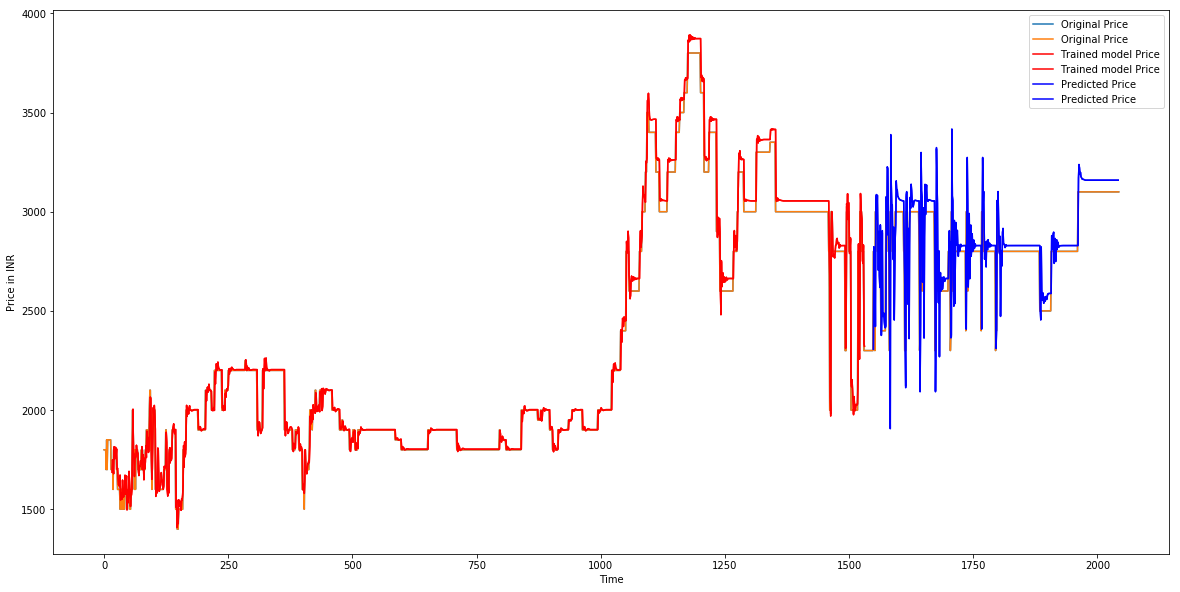

In [30]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(scaled)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled),label = 'Original Price')
plt.plot(trainPredictPlot, color = 'red', label = 'Trained model Price')
plt.plot(testPredictPlot, color = 'blue', label = 'Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price in INR')
plt.legend()
#plt.plot(x='Arrival Date')
plt.show()